### Load in CAMS data

In [2]:
import netCDF4 as nc
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.colors import LinearSegmentedColormap
import cartopy.crs as ccrs
import os
import math
#import imageio
from scipy.ndimage.interpolation import map_coordinates
from pprint import pprint
import glob
from scipy import interpolate
from scipy.interpolate import RegularGridInterpolator
from copy import copy
from copy import deepcopy
#from mpl_toolkits.axes_grid1 import make
#_axes_locatable
%matplotlib inline
from scipy import stats
import multiprocessing as mp
import matplotlib.patches as patches

In [3]:
_wbgyr_cdict = {'red': ((0.0,  255./255, 255./255),
                        (0.125, 173./255, 173./255),
                        (0.25,  95./255,  95./255),
                        (0.375, 73./255,  73./255),
                        (0.5,  165./255, 164./255),
                        (0.625, 248./255, 248./255),
                        (0.75, 236./255, 236./255),
                        (0.875, 200./255, 200./255),
                        (1.0,  146./255, 146./255)),
                'green': ((0.0,  255./255, 255./255),
                          (0.125, 224./255, 224./255),
                          (0.25, 163./255, 163./255),
                          (0.375, 166./255, 166./255),
                          (0.5,  207./255, 207./255),
                          (0.625, 184./255, 184./255),
                          (0.75,  86./255,  86./255),
                          (0.875, 29./255,  29./255),
                          (1.0,   21./255,  21./255)),
                'blue': ((0.0,  255./255, 255./255),
                         (0.125, 248./255, 248./255),
                         (0.25, 214./255, 214./255),
                         (0.375, 120./255, 120./255),
                         (0.5,   81./255,  81./255),
                         (0.625, 73./255,  73./255),
                         (0.75,  41./255,  41./255),
                         (0.875, 38./255,  38./255),
                         (1.0,   25./255,  25./255))}
# And reverse
_wbgyr_cdict_r = deepcopy(_wbgyr_cdict)
for i in _wbgyr_cdict_r.keys():
    _wbgyr_cdict_r[i] = [(1-j[0], j[1], j[2]) for j in _wbgyr_cdict_r[i]]
    _wbgyr_cdict_r[i].reverse()

cmap = LinearSegmentedColormap('WBGYR', _wbgyr_cdict)
cmap.set_bad('#D2D2D2')
plt.register_cmap(cmap=cmap)

cmap_r = LinearSegmentedColormap('WBGYR', _wbgyr_cdict_r)
cmap_r.set_bad('#D2D2D2')
plt.register_cmap(cmap=cmap_r)

In [4]:
CAMS = xr.open_mfdataset('/disk1/Data/CAMS/aerosol_levels/2008/*/rg*.nc')
TSC = xr.open_mfdataset('/net/seldon/disk2/Users/gah20/TSCISCCP/TSC_testdelete/2008/TSC_*.nc',combine='nested', concat_dim="time")['TSC']

In [35]:
CAMS['time']

<xarray.DataArray 'time' (time: 2920)>
array(['2008-01-01T00:00:00.000000000', '2008-01-01T03:00:00.000000000',
       '2008-01-01T06:00:00.000000000', ..., '2008-12-31T15:00:00.000000000',
       '2008-12-31T18:00:00.000000000', '2008-12-31T21:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2008-01-01 ... 2008-12-31T21:00:00
Attributes:
    standard_name:  time
    long_name:      time
    axis:           T

In [6]:
so2 = CAMS['so2']
/disk1/Users/gah20/CAMS_data.ipynb

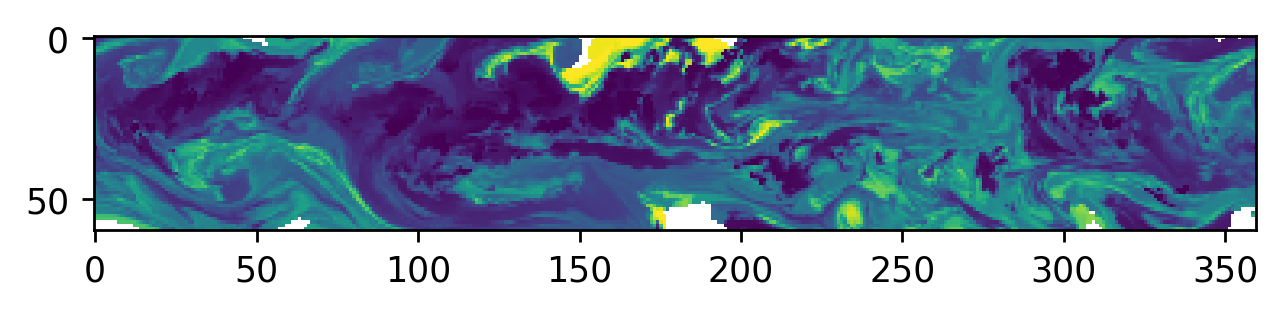

In [70]:
plt.figure(dpi=250)
plt.imshow(TSC[0,2:62])

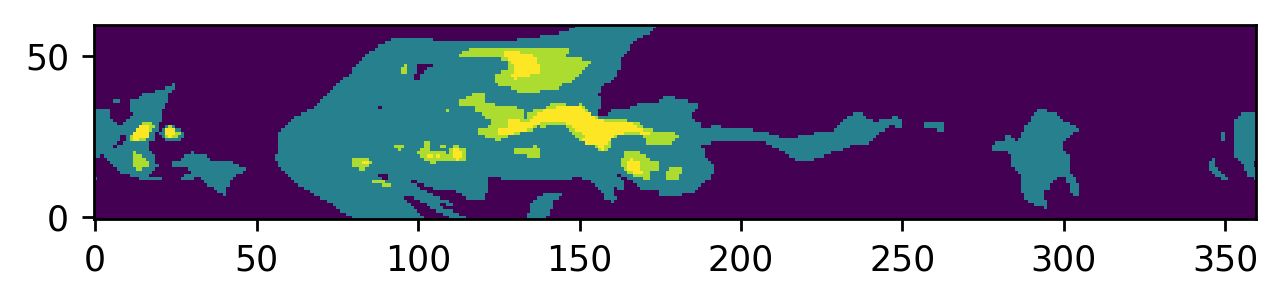

In [22]:
plt.figure(dpi=250)
plt.imshow(so2[9,0,60:120],vmax=0.0000000001,origin='lower')

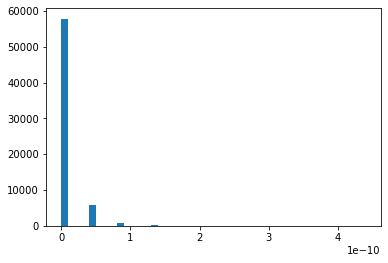

In [25]:
plt.hist(np.asarray(so2[0,0]).flatten(),bins=(np.arange(0,4.5e-10,1e-11)))
plt.show()

In [13]:
np.arange(5e-11,4.5e-10,7e-11).shape

(6,)

In [14]:
from tqdm import tqdm

xbins = np.arange(0,24,1)
ybins = np.arange(0,4e-10,6e-11)
h = np.zeros((10,23,6))

for k in tqdm(range(10)):
    for i in range(2000,2500):
        h0,x,y = np.histogram2d(np.asarray(TSC[3*i,2:62]).flatten(),np.asarray(so2[i,k,60:120]).flatten(),bins=(xbins,ybins))
        h[k] = h[k] + h0

H_norm = np.zeros((10,23,6))
for i in range(23):
    H_norm[:,i,:] = h[:,i,:] / np.sum(h[:,i,:])

AVERAGE_RH = np.zeros((10,23))
for i in range(23):
    for j in range(10):
        AVERAGE_RH[j,i] = np.average(np.arange(5e-11,4.5e-10,7e-11), weights=H_norm[j,i,:])

100%|██████████| 10/10 [02:48<00:00, 16.85s/it]


Text(0, 0.5, 'Height Levels')

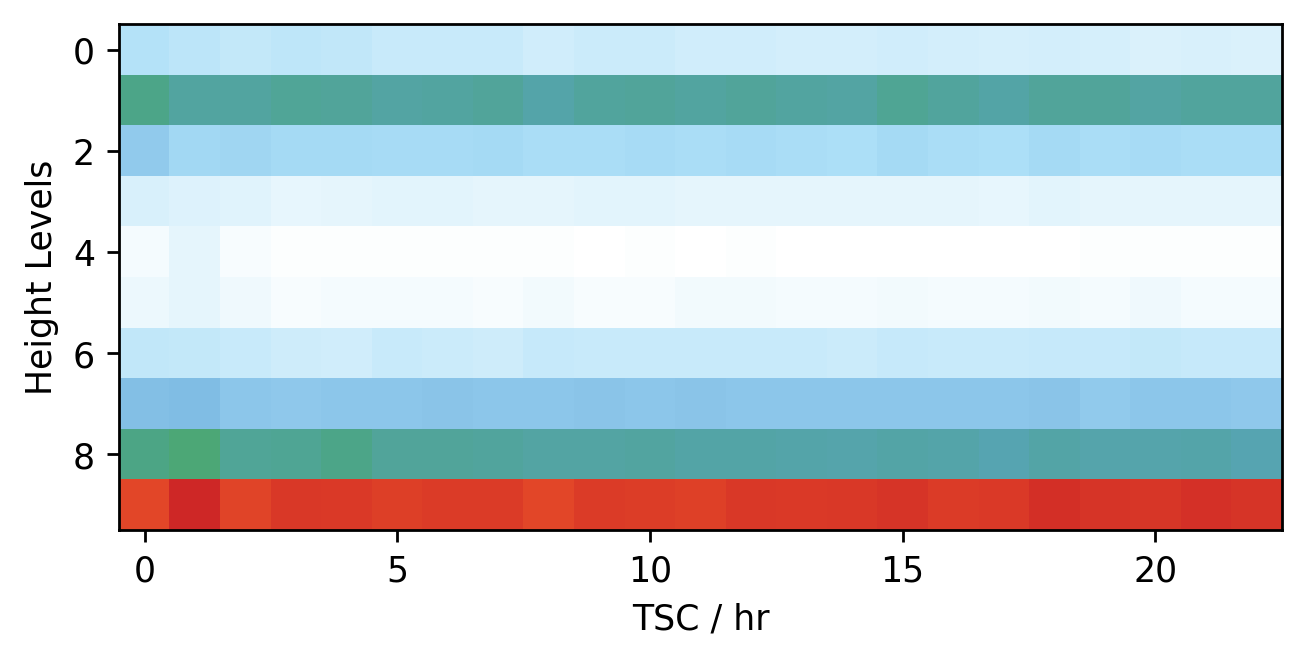

In [18]:
plt.figure(dpi=250)
plt.imshow(AVERAGE_RH,vmax=0.00000000015,cmap=cmap)
plt.xlabel('TSC / hr')
plt.ylabel('Height Levels')

In [6]:
aod11 = CAMS['so2']

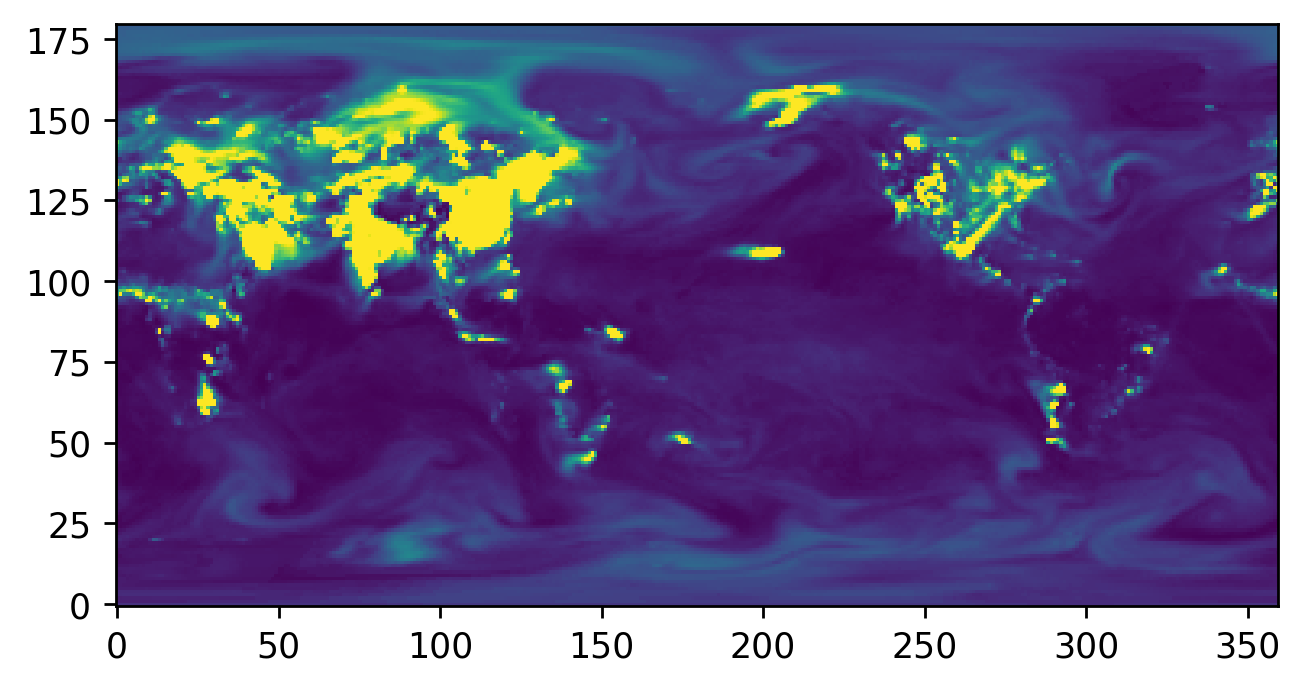

In [39]:
plt.figure(dpi=250)

plt.imshow(np.nansum(aod11[0],axis=0),vmax=0.00000001,interpolation='none',origin='lower',cmap='viridis')

In [35]:
aod8 = CAMS['aermr01']
aod10 = CAMS['aermr02']
aod9 = CAMS['aermr03']
aod1 = CAMS['aermr04']
aod2 = CAMS['aermr06']
aod4 = CAMS['aermr07']
aod5 = CAMS['aermr08']
aod3 = CAMS['aermr09']
aod6 = CAMS['aermr10']
aod7 = CAMS['aermr11']
aod11 = CAMS['so2']

total_aod = np.nansum([aod1, aod2, aod3, aod4, aod5, aod6, aod7, aod8, aod9, aod10, aod11], axis=0)


In [68]:
totalmeanavgt = np.nansum(total_aod,axis=1)

In [26]:
TSC

<xarray.DataArray 'TSC' (time: 8784, lat: 64, lon: 360)>
dask.array<concatenate, shape=(8784, 64, 360), dtype=float32, chunksize=(24, 64, 360), chunktype=numpy.ndarray>
Dimensions without coordinates: time, lat, lon

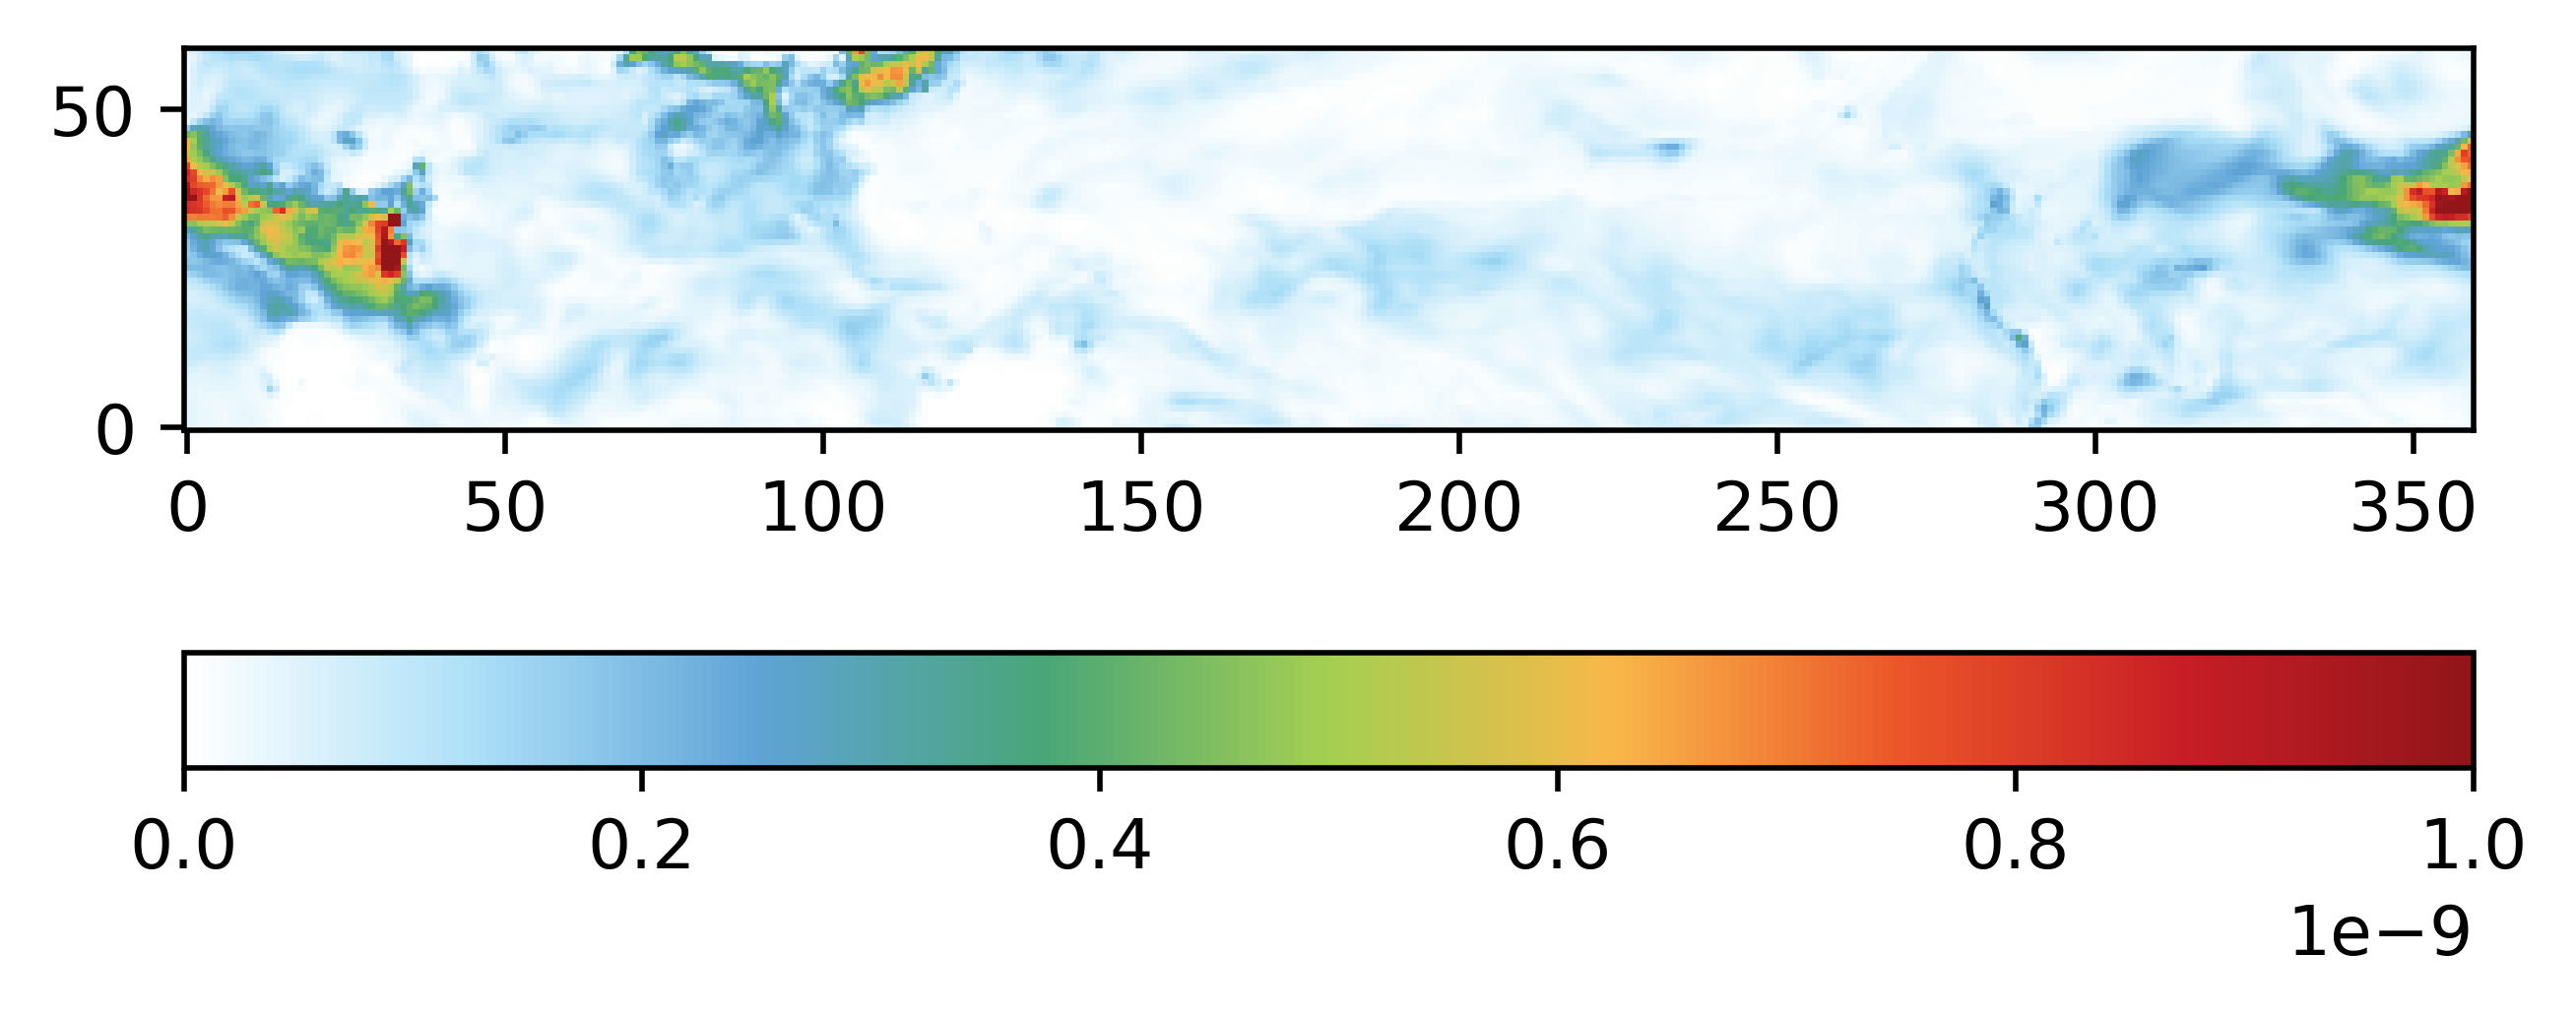

In [27]:
plt.figure(dpi=500)
im=plt.imshow(columnavg[0,60:120],vmax=0.000000001,cmap=cmap,origin='lower')
plt.colorbar(im,orientation='horizontal')

In [61]:
lifetime =xr.open_mfdataset('/disk1/Users/gah20/TSC/200[7-9]/*.nc',combine='nested', concat_dim="time")['Lifetime']
oceanland = xr.open_mfdataset('/disk1/Users/gah20/TSC/200[7-9]/*.nc',combine='nested', concat_dim="time")['ConvOrigin']

/home/gah20/.conda/envs/py3_jl/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: Mean of empty slice
  


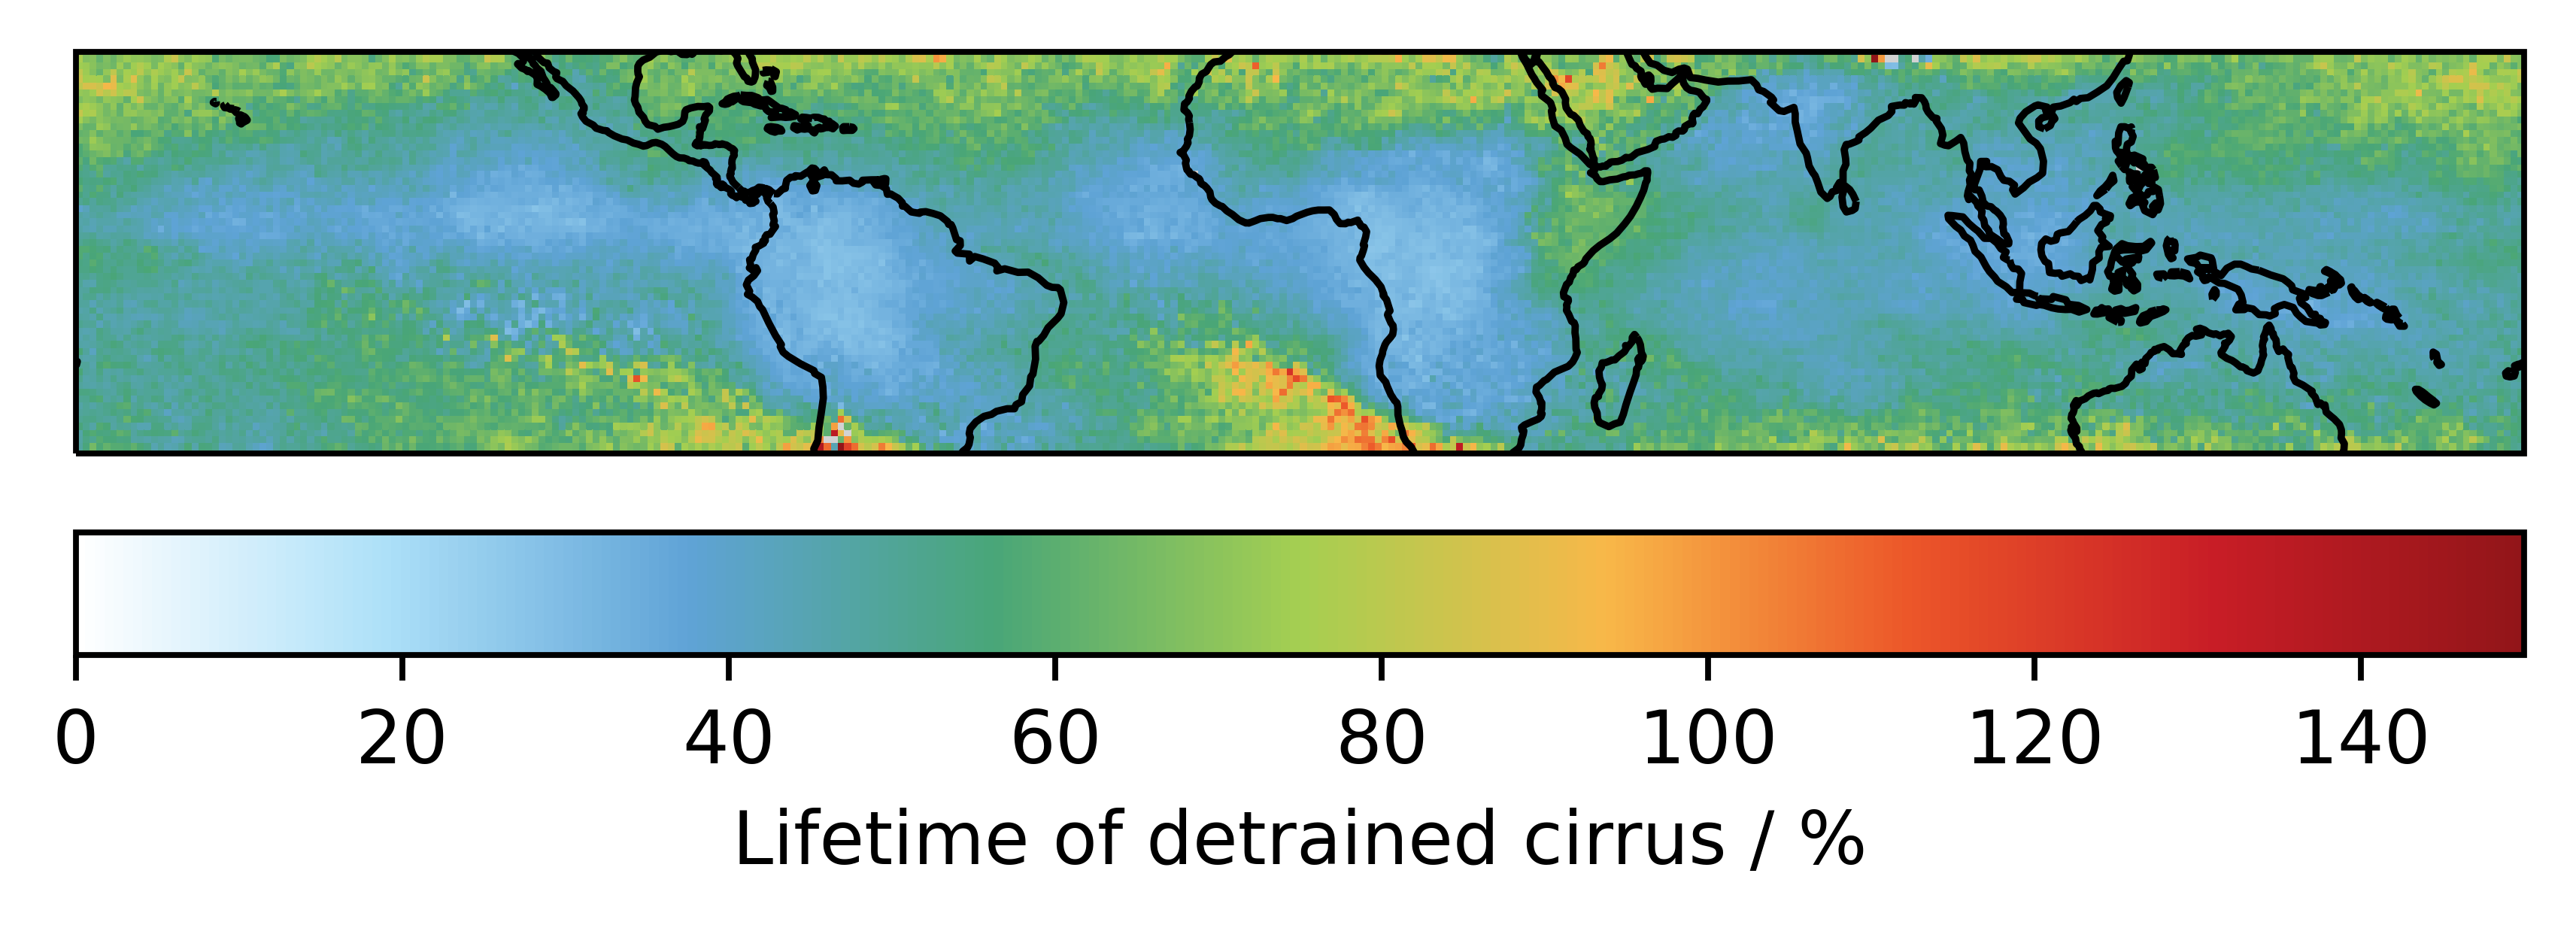

In [95]:
fig = plt.figure(dpi=700)
img_extent = (-180,180,-30,30)
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-180,180,-29.5,29.5],ccrs.PlateCarree())
ax.coastlines()
im=plt.imshow(np.nanmean(lifetime[500:,2:62],axis=0),origin='lower',extent=img_extent,transform=ccrs.PlateCarree(central_longitude=180),interpolation='none',cmap=cmap,alpha=1,vmin=0,vmax=150)
plt.colorbar(im,orientation='horizontal',pad=0.05,label='Lifetime of detrained cirrus / %')
plt.savefig('paper2plots/LifetimeMap.pdf',dpi=1000,bbox_inches='tight')


In [62]:
landlifetime=np.where(oceanland>0,lifetime,np.nan)
oceanlifetime=np.where(oceanland<0,lifetime,np.nan)

In [83]:
meanlifetimeland=np.nanmean(landlifetime[500:,2:62])
meanlifetimeocean=np.nanmean(oceanlifetime[500:,2:62])
meanlifetime=np.nanmean(lifetime[500:,2:62])

In [82]:
meanlifetimeland

31.048248

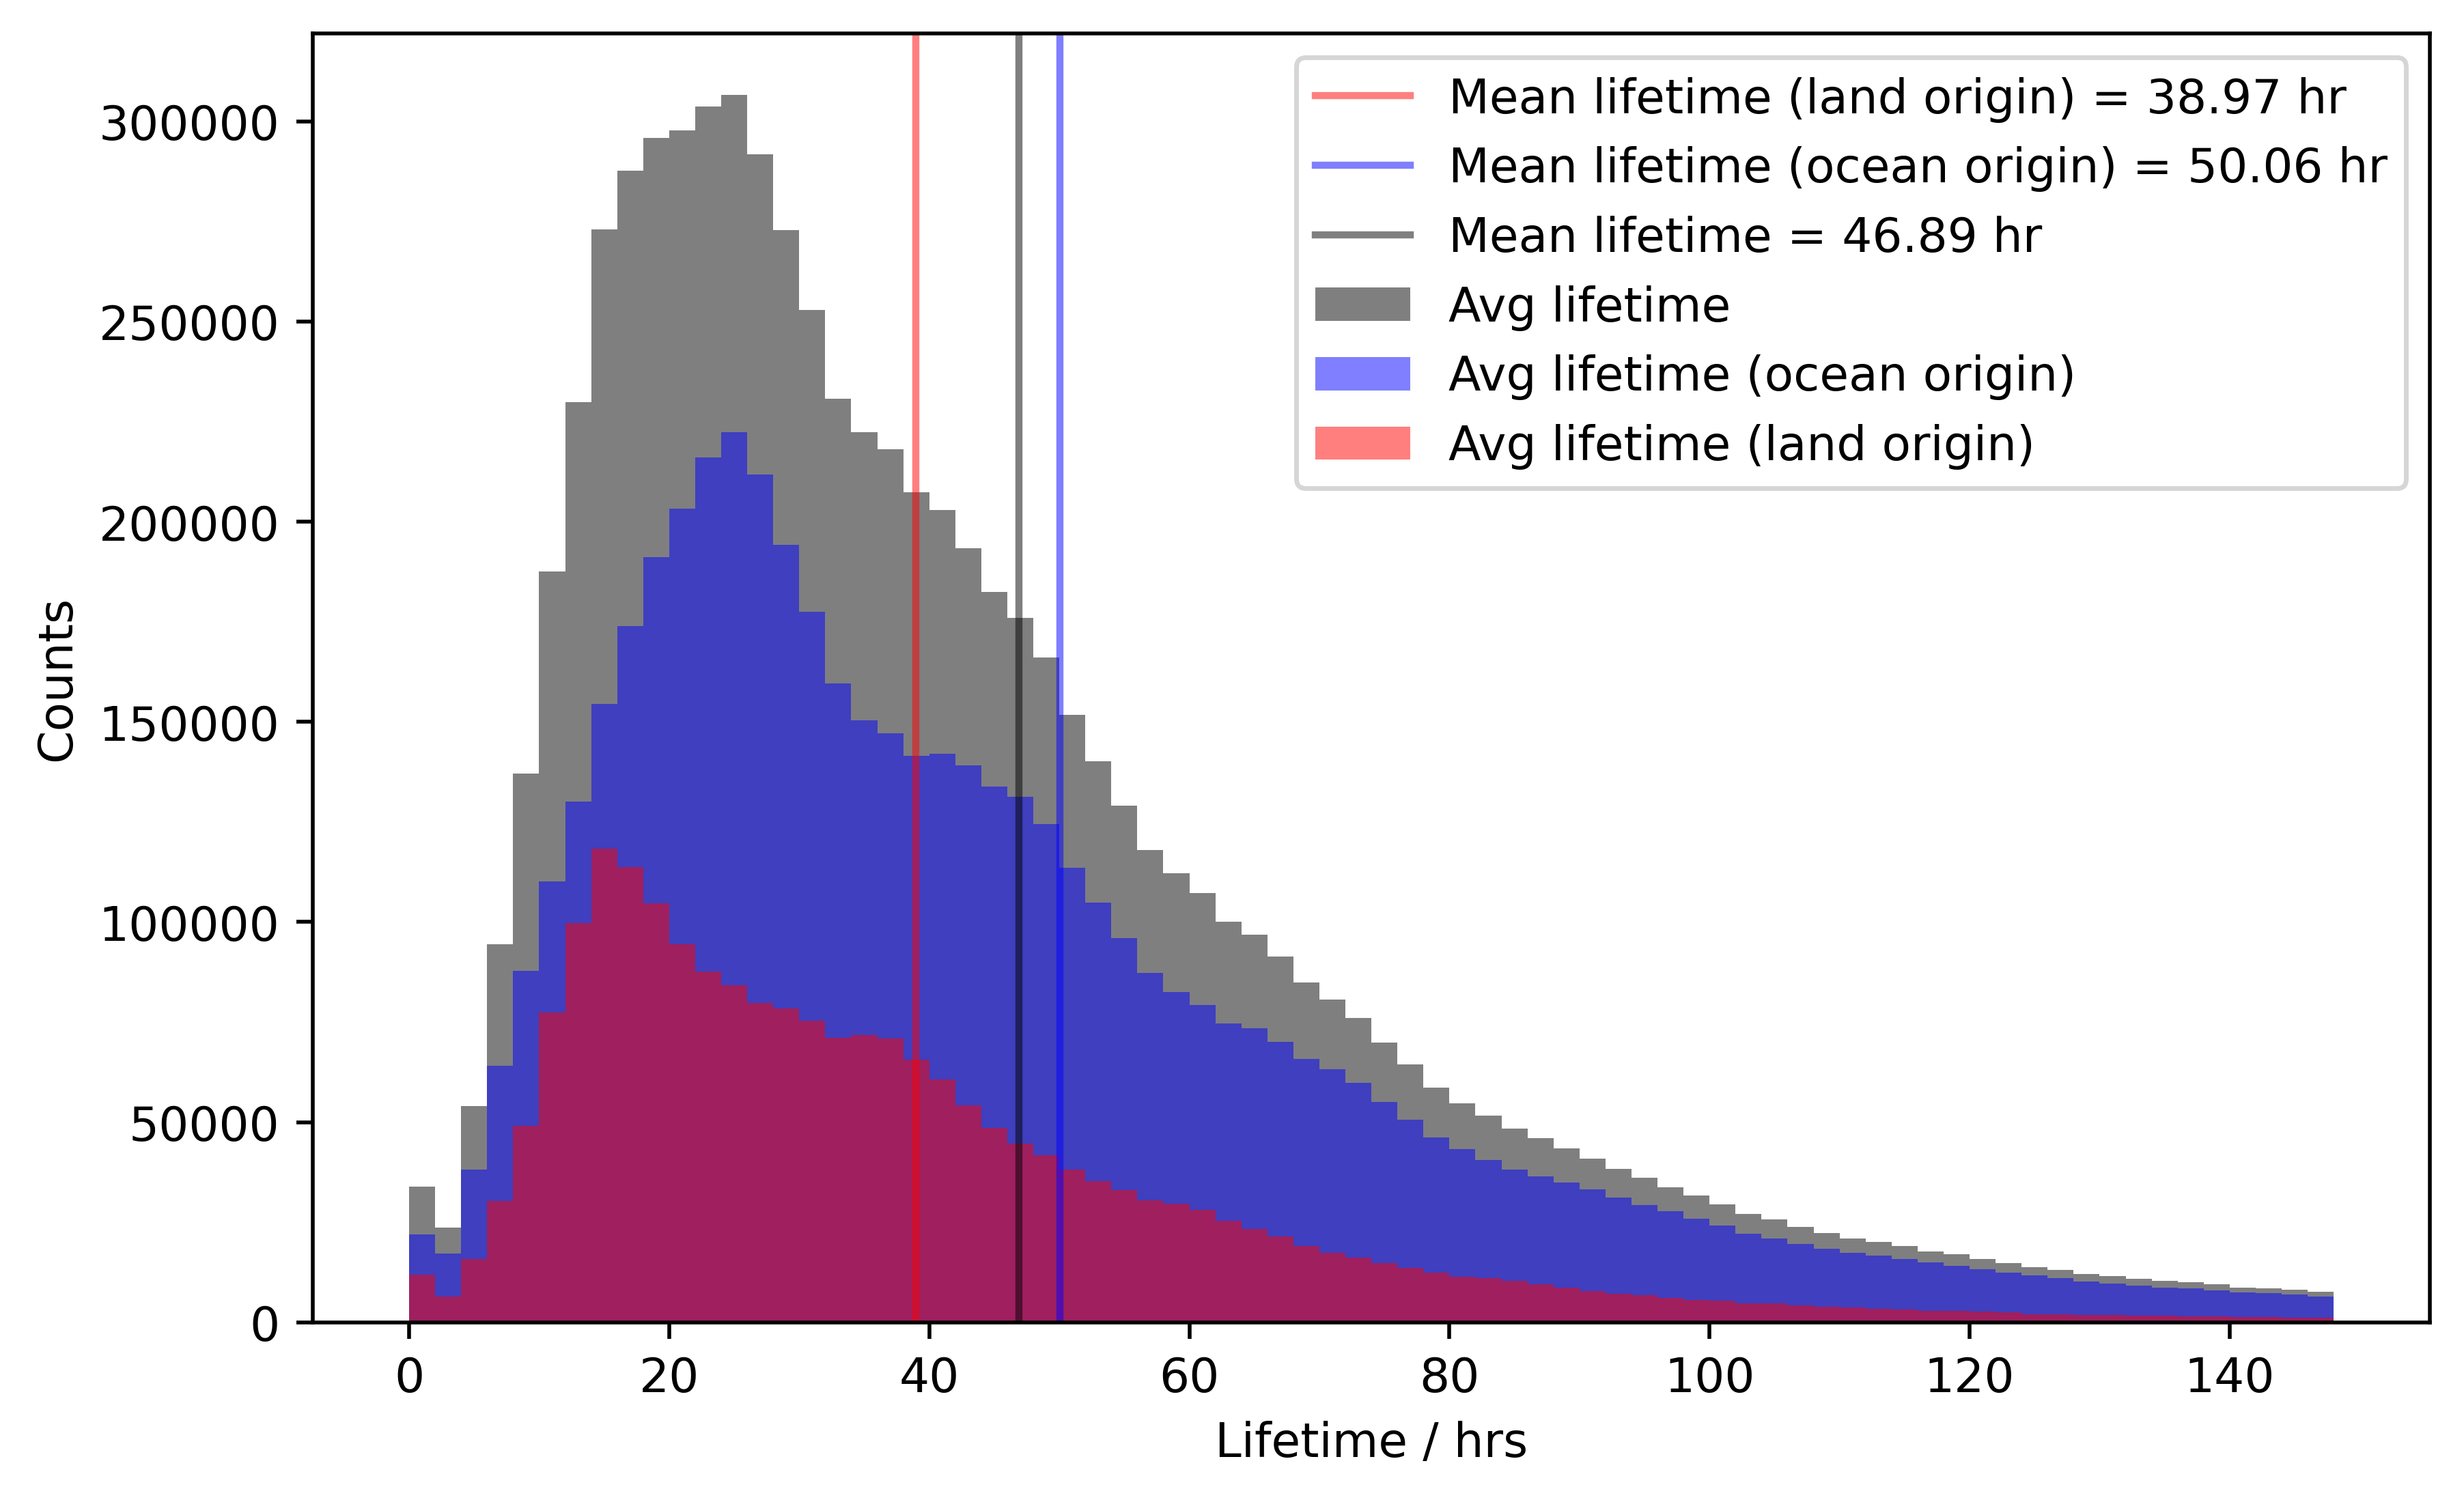

In [96]:
plt.figure(dpi=500,figsize=(8,5))
plt.hist(np.asarray(lifetime[500:,2:62]).flatten(),bins=(np.arange(0,150,2)),alpha=0.5,label='Avg lifetime',color='black')
plt.hist(np.asarray(oceanlifetime[500:,2:62]).flatten(),bins=(np.arange(0,150,2)),alpha=0.5,label='Avg lifetime (ocean origin)',color='blue')
plt.hist(np.asarray(landlifetime[500:,2:62]).flatten(),bins=(np.arange(0,150,2)),alpha=0.5,label='Avg lifetime (land origin)',color='red')

plt.axvline(meanlifetimeland,color='red',label='Mean lifetime (land origin) = '+str(round(meanlifetimeland,2))+' hr',alpha=0.5)
plt.axvline(meanlifetimeocean,color='blue',label='Mean lifetime (ocean origin) = '+str(round(meanlifetimeocean,2))+' hr',alpha=0.5)
plt.axvline(meanlifetime,color='black',label='Mean lifetime = ' +str(round(meanlifetime,2))+' hr',alpha=0.5)
plt.legend()
plt.xlabel('Lifetime / hrs')
plt.ylabel('Counts')
plt.savefig('paper2plots/lifetimehistograms.png',dpi=1500)

/home/gah20/.conda/envs/py3_jl/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: Mean of empty slice
  


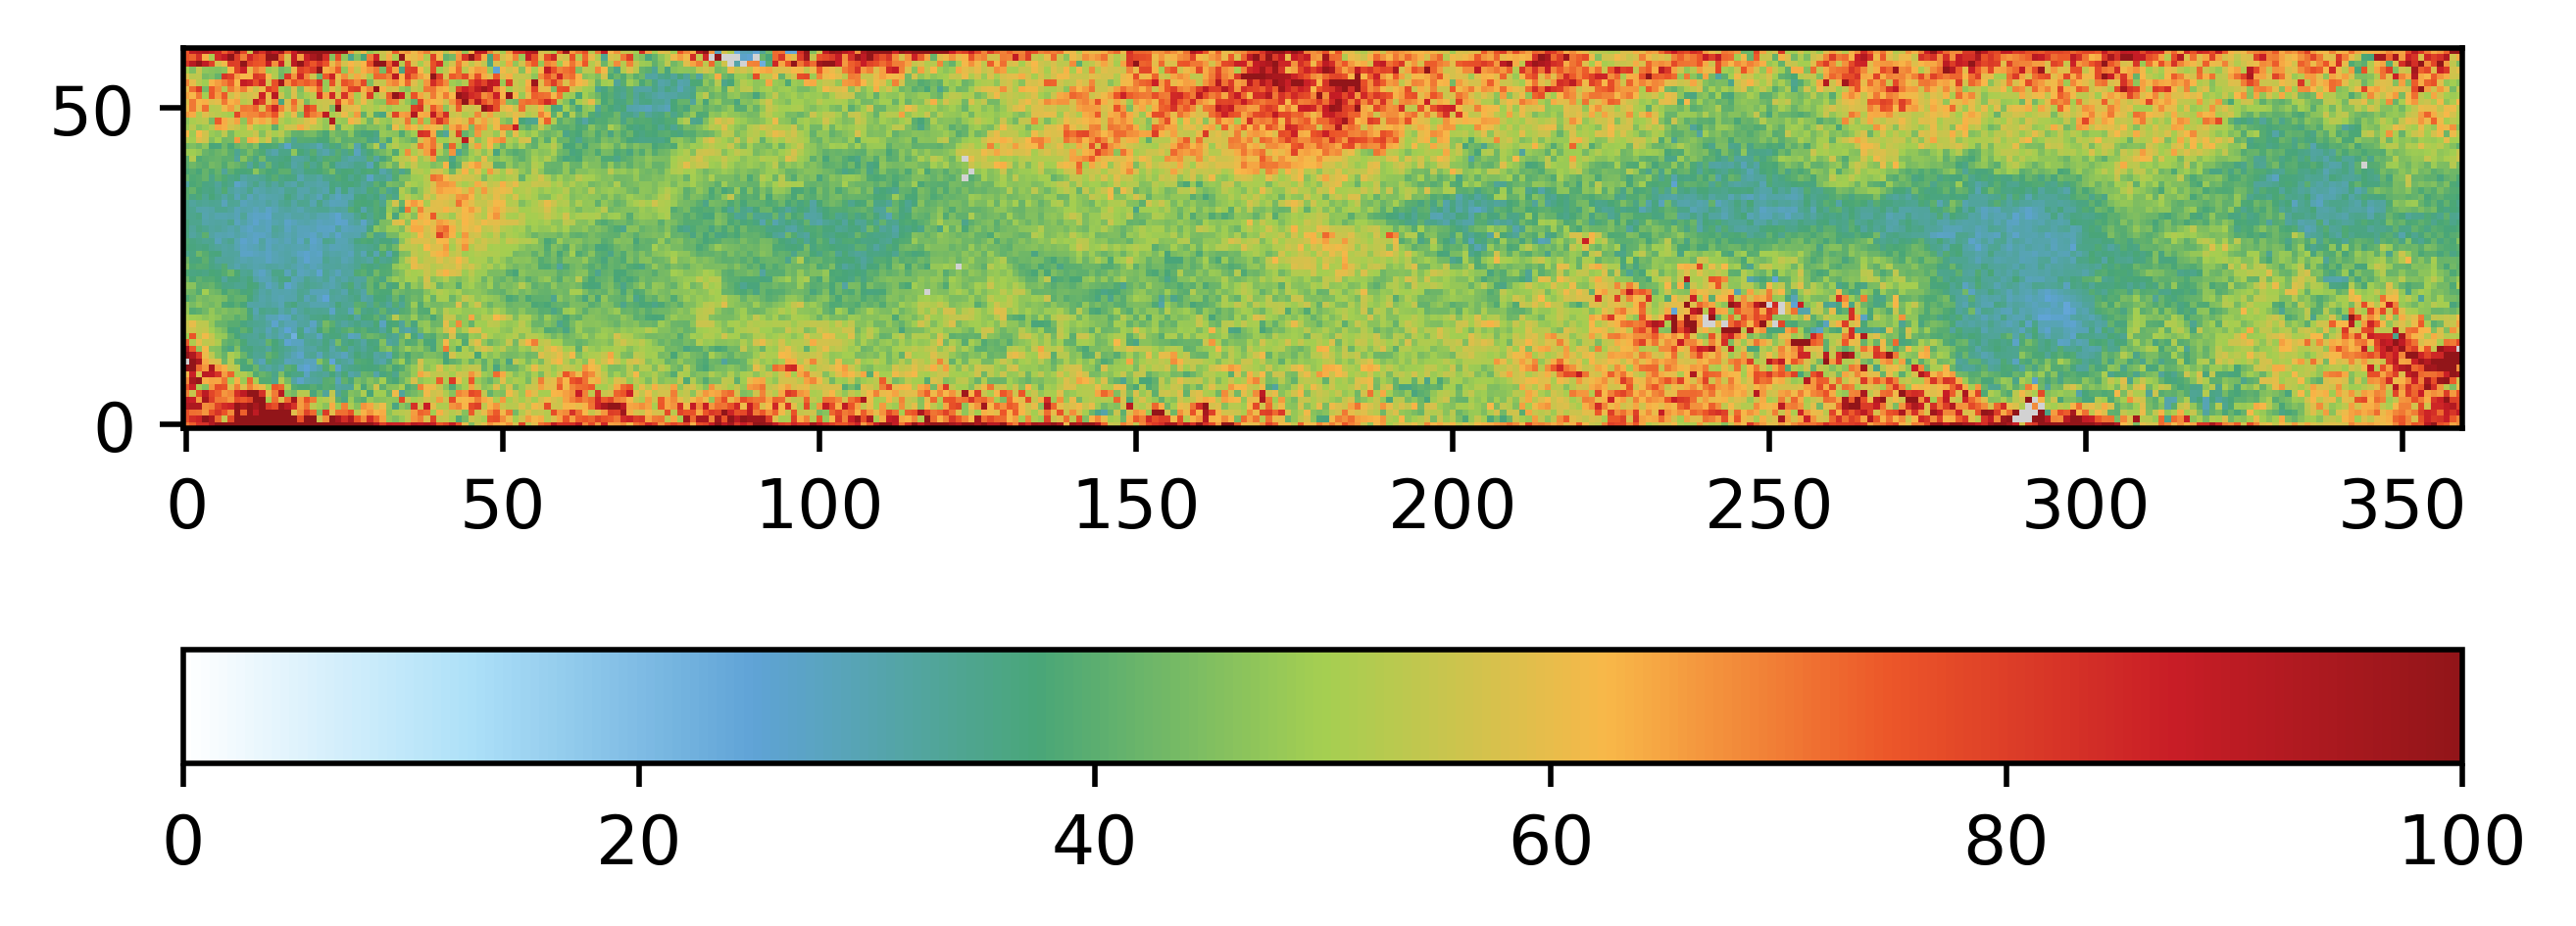

In [43]:
plt.figure(dpi=500)
plt.imshow(np.nanmean(lifetime[:,2:62],axis=0),interpolation='none',cmap=cmap,vmin=0,vmax=100,origin='lower')
plt.colorbar(orientation='horizontal')